In [1]:
library(glmmSeq)
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



In [3]:
load('h5ad/df.fil3_gex_bcells_vdj_sce_ASC_all_deg.RData')
ls()

[1] "res1"     "res2"     "res3"     "results1" "results2" "results3"

In [4]:
library(dplyr)
makeGeneList <- function(gl, beta_column='LFC'){
    y <- grepl('^RPS|^RPL|^MT-', row.names(gl))
    gl <- gl[!y, ]
    rank <- -log10(gl$pval) * sign(gl[,beta_column])
    rank[which(rank == Inf)] <- 300
    rank[which(rank == -Inf)] <- 300
    names(rank) <- row.names(gl)
    rank <- rev(sort(rank))
    gl <- rank
    return(gl)
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
head(results1)
dim(results1)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FAM92B,1.669524,1.153432e-04,5.224113e-04,1.854373,0,0
AC233755.1,1.523223,1.807601e-148,1.416596e-147,2.195236,0,0
TUBB6,1.300332,6.135999e-02,9.375578e-02,1.346146,0,0
COL24A1,1.275764,1.776391e-03,5.569583e-03,1.428700,0,0
SMOX,1.236528,4.365311e-04,1.687069e-03,1.649244,0,0
FAM78A,1.232011,8.071723e-07,4.889290e-06,1.464194,0,0


[1] 6289    6

In [6]:
head(results2)
dim(results2)

,fixed-effects estimates_linear,fixed-effects estimates_quadratic,pval,qval,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SYT1,13.231420,6.694806,9.314935e-05,1.760454e-04,0,0
SLAMF1,11.261660,5.310984,4.910854e-07,1.433015e-06,0,0
RECQL5,12.882421,5.228561,3.225524e-07,9.802739e-07,0,0
POFUT1,8.798114,4.762513,1.671598e-05,3.632185e-05,0,0
MGA,9.468402,4.463263,1.455255e-06,3.880008e-06,0,0
FXR2,11.256019,4.443824,8.838819e-12,5.028712e-11,0,0


[1] 5593    6

In [8]:
head(results3)
dim(results3)

,fixed-effects estimates,pval,qval,LFC,Singular,Conv
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FAM92B,2.132402,8.321060e-04,0.017375137,1.996935,0,0
BFSP2,2.029216,4.210484e-05,0.002977612,1.861237,0,0
IGHE,2.026011,8.420661e-02,0.091767186,2.201329,0,0
IGHG1,2.019252,8.169906e-05,0.005461710,2.911088,0,0
TCL1A,1.968036,2.934106e-04,0.013104536,1.896371,0,0
ACOXL,1.860094,1.362752e-03,0.017375137,1.772690,0,0


[1] 8361    6

In [9]:
# head(results4)
# dim(results4)

In [10]:
# head(results5)
# dim(results5)

In [11]:
library(fgsea)
library(msigdbr)

In [12]:
h <- data.frame(msigdbr::msigdbr(category = "H", species = 'Homo sapiens'))
h <- split(h, h$gs_name)
h <- lapply(h, function(x) x %>% dplyr::select(gene_symbol) %>% unlist %>% as.character)

In [13]:
plotGSEA_Hallmark <- function(gsea, fdr_cutoff = 0.05, cols = NULL, xlim = NULL, newlabels = NULL, keep_significant_only = TRUE, jitter = FALSE) {
    require(ggplot2)
    gsea$NES[which(is.na(gsea$NES))] <- 0
    gsea$pval[which(is.na(gsea$pval))] <- 1
    gsea$padj[which(is.na(gsea$padj))] <- 1
    gsea$ranking[which(is.na(gsea$ranking))] <- 0
    gsea <- gsea[order(gsea$ranking),]
    
    if (keep_significant_only){
        gseax <- split(gsea, gsea$pathway)
        for (i in 1:length(gseax)){
            if (all(gseax[[i]]$pval >= 0.05)|all(gseax[[i]]$padj >=fdr_cutoff)){
                gseax[[i]] <- NA        
            }
        }
        gseax <- gseax[!is.na(gseax)]
        gsea <- do.call(rbind, gseax)        
    }
    if (!is.null(gsea)){
        gsea <- gsea[order(gsea$ranking), ]
        gsea$pathway <- gsub("HALLMARK_|", "", gsea$pathway)

        if (!is.null(xlim)){
            x_lim_min = -xlim
            x_lim_max = xlim
        } else {
            x_lim_min <- abs(ceiling(min(-log10(gsea$padj))))
            x_lim_max <- abs(ceiling(max(-log10(gsea$padj))))
        }
        
        if(x_lim_min > x_lim_max){
            xval1 <- x_lim_min * -1
            xval2 <- x_lim_min
        } else {
            xval1 <- x_lim_max * -1
            xval2 <- x_lim_max
        }

        if(!is.null(cols)){
            gg_color_hue <- function(n) {
                hues = seq(15, 375, length = n + 1)
                hcl(h = hues, l = 65, c = 100)[1:n]
            }
            cols. = gg_color_hue(dplyr::n_distinct(gsea$group, na.rm = TRUE))
        } else {
            cols. = cols
        }    
    
        g <- ggplot(gsea, aes(x = -log10(padj)*sign(NES), y = reorder(pathway, ranking), col = -log10(padj)*sign(NES), size = abs(NES)))
        if (jitter){
            g <- g + geom_point(position = 'jitter')
        }else{
            g <- g + geom_point()
        }
        g <- g + theme_bw() +
            labs(x = expression(paste("Signed", " -log" ["10"], "adjusted pval")), y = "Hallmarks") +
            geom_vline(xintercept = 0) +
            geom_vline(xintercept = -log10(fdr_cutoff)) +
            geom_vline(xintercept = -log10(fdr_cutoff)*-1) +
            scale_x_continuous(limits = c(xval1, xval2), oob = scales::squish) +
            scale_size_area(oob = scales::squish, max_size = 3, limits = c(0,2)) +
            theme(panel.grid.major = element_blank(), 
                panel.grid.minor = element_blank(), 
                panel.background = element_blank(), 
                axis.line = element_blank(), 
                axis.ticks = element_blank(),
                axis.text = element_text(color = 'black'),
                axis.title = element_text(color = 'black'))
        
        return(g)
    }
}

In [14]:
gl1 <- makeGeneList(results1)
res1gsea <- fgsea(pathways = h, stats = gl1, minSize = 0, maxSize =1000)
res1gsea$ranking <- -log10(res1gsea$pval) * sign(res1gsea$NES)
plotGSEA_Hallmark(res1gsea)

Warning message in fgseaMultilevel(...):
“There were 4 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”
Loading required package: ggplot2



Warning message in fgseaMultilevel(...):
“There were 3 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


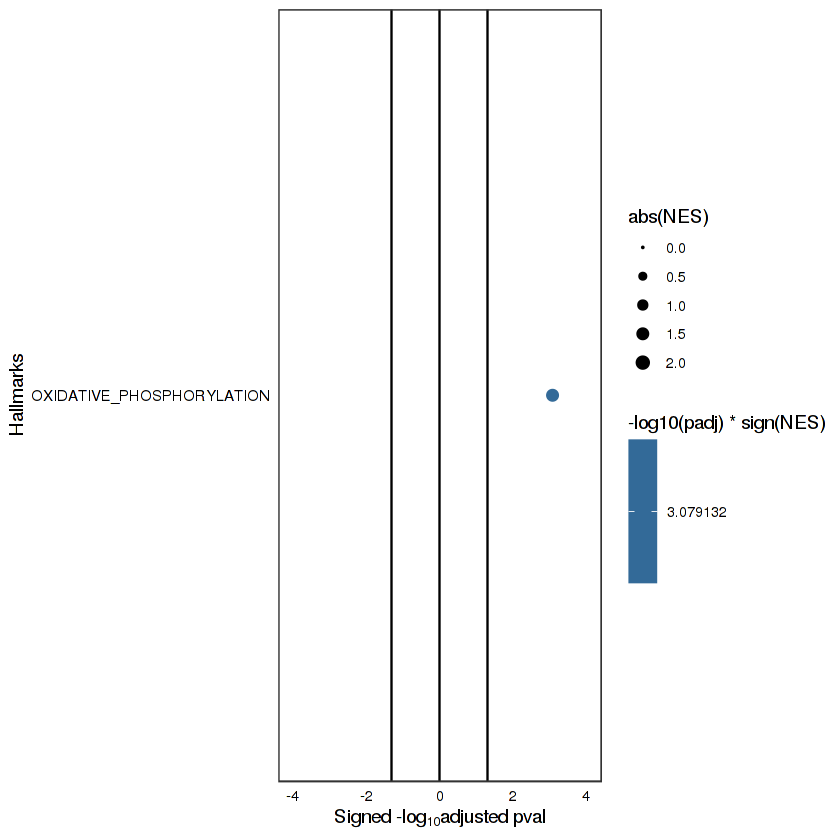

In [15]:
gl2 <- makeGeneList(results2, 'fixed-effects estimates_linear')
res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
plotGSEA_Hallmark(res2gsea)

Warning message in fgseaMultilevel(...):
“There were 4 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


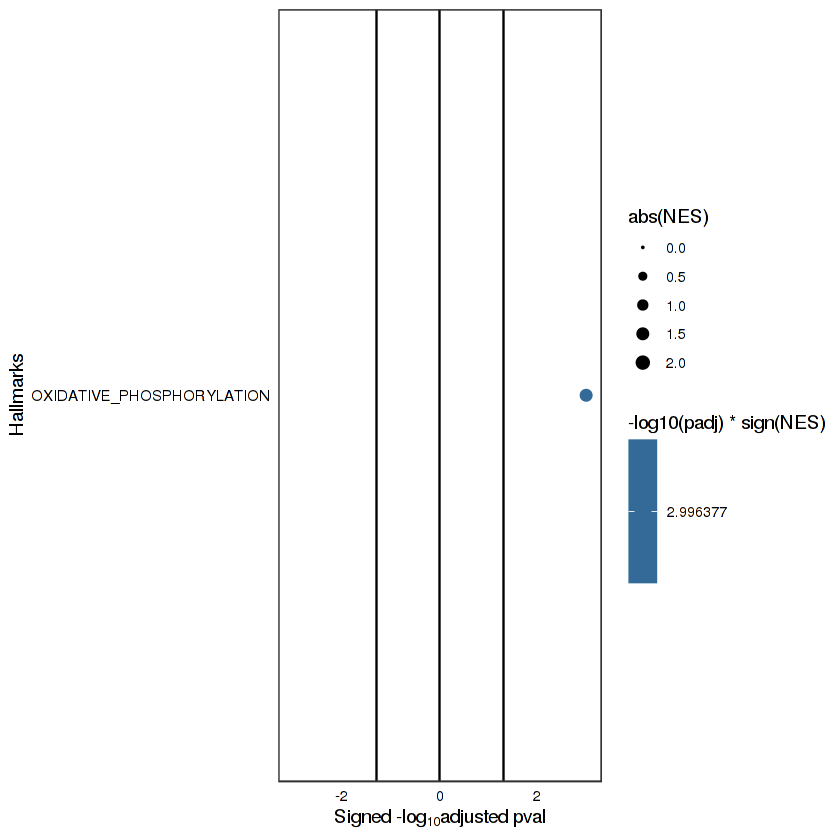

In [16]:
gl2 <- makeGeneList(results2, 'fixed-effects estimates_quadratic')
res2gsea <- fgsea(pathways = h, stats = gl2, minSize = 0, maxSize =1000)
res2gsea$ranking <- -log10(res2gsea$pval) * sign(res2gsea$NES)
plotGSEA_Hallmark(res2gsea)

Warning message in fgseaMultilevel(...):
“There were 2 pathways for which P-values were not calculated properly due to unbalanced (positive and negative) gene-level statistic values. For such pathways pval, padj, NES, log2err are set to NA. You can try to increase the value of the argument nPermSimple (for example set it nPermSimple = 10000)”


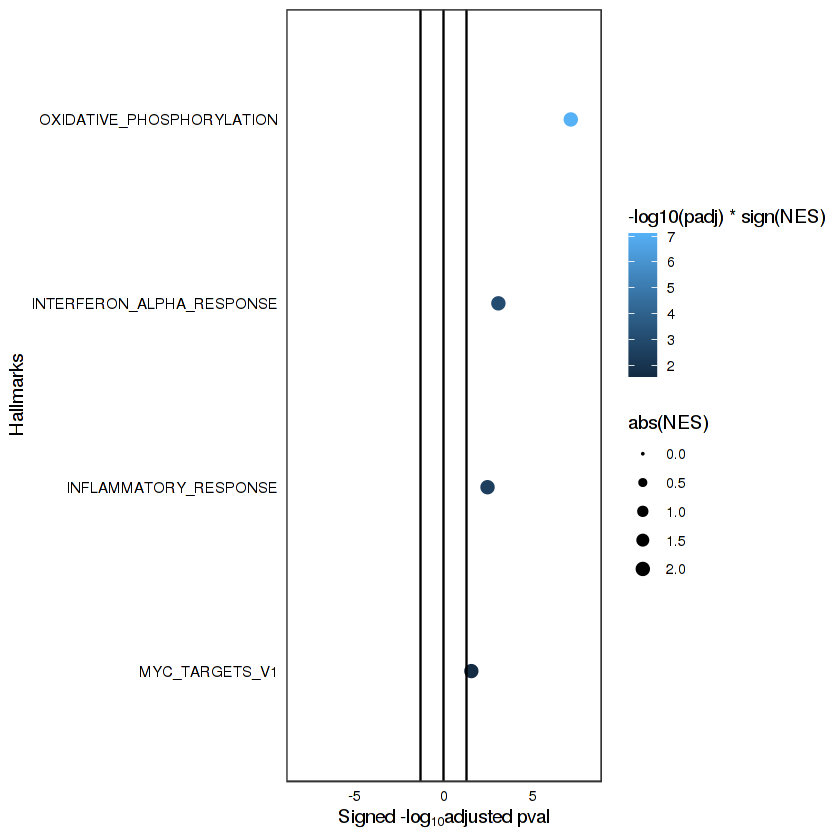

In [17]:
gl3 <- makeGeneList(results3)
res3gsea <- fgsea(pathways = h, stats = gl3, minSize = 0, maxSize =1000)
res3gsea$ranking <- -log10(res3gsea$pval) * sign(res3gsea$NES)
plotGSEA_Hallmark(res3gsea)

In [18]:
# gl4 <- makeGeneList(results4)
# res4gsea <- fgsea(pathways = h, stats = gl4, minSize = 0, maxSize =1000)
# res4gsea$ranking <- -log10(res4gsea$pval) * sign(res4gsea$NES)
# plotGSEA_Hallmark(res4gsea)

In [19]:
# res4gsea

In [20]:
# res4gsea[res4gsea$pathway %in% c('HALLMARK_TNFA_SIGNALING_VIA_NFKB', 'HALLMARK_HYPOXIA', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_INFLAMMATORY_RESPONSE'),'leadingEdge']

In [21]:
# gl5 <- makeGeneList(results5)
# res5gsea <- fgsea(pathways = h, stats = gl5, minSize = 0, maxSize =1000)
# res5gsea$ranking <- -log10(res5gsea$pval) * sign(res5gsea$NES)
# plotGSEA_Hallmark(res5gsea)